<img align="left" src="https://ithaka-labs.s3.amazonaws.com/static-files/images/tdm/tdmdocs/CC_BY.png"><br />

Created by [Nathan Kelber](http://nkelber.com) and Ted Lawless for [JSTOR Labs](https://labs.jstor.org/) under [Creative Commons CC BY License](https://creativecommons.org/licenses/by/4.0/)<br />
For questions/comments/improvements, email nathan.kelber@ithaka.org.<br />
___

**Finding Significant Words Using TF/IDF**

**Description of methods in this notebook:**
This [notebook](https://docs.tdm-pilot.org/key-terms/#jupyter-notebook) shows how to discover significant words in your [JSTOR](https://docs.tdm-pilot.org/key-terms/#jstor) and/or [Portico](https://docs.tdm-pilot.org/key-terms/#portico) [dataset](https://docs.tdm-pilot.org/key-terms/#dataset) using [Python](https://docs.tdm-pilot.org/key-terms/#python). The method for finding significant terms is [tf-idf](https://docs.tdm-pilot.org/key-terms/#tf-idf).  The following processes are described:

* Converting your [JSTOR](https://docs.tdm-pilot.org/key-terms/#jstor)/[Portico](https://docs.tdm-pilot.org/key-terms/#portico) [dataset](https://docs.tdm-pilot.org/key-terms/#dataset) into a Python list
* Filtering out articles from your [dataset](https://docs.tdm-pilot.org/key-terms/#dataset) depending on a flexible set of rules
* Writing a helper function to help clean up a single [token](https://docs.tdm-pilot.org/key-terms/#token)
* Cleaning each document of your dataset, one [token](https://docs.tdm-pilot.org/key-terms/#token) at a time
* Using htrc_dictionary to remove words with poor [OCR](https://docs.tdm-pilot.org/key-terms/#ocr)
* Creating a [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary)
* Creating a [gensim](https://docs.tdm-pilot.org/key-terms/#gensim) [bag of words]((https://docs.tdm-pilot.org/key-terms/#bag-of-words) [corpus](https://docs.tdm-pilot.org/key-terms/#corpus)
* Computing the most significant words in your [corpus](https://docs.tdm-pilot.org/key-terms/#corpus) using [gensim](https://docs.tdm-pilot.org/key-terms/#gensim) implementation of [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf)

**Difficulty:** Intermediate

**Knowledge Required:** 
* [Python Basics I](./0-python-basics-1.ipynb)
* [Python Basics II](./0-python-basics-2.ipynb)
* [Python Basics III](./0-python-basics-3.ipynb)

**Knowledge Recommended:**
* [Exploring Metadata](./1-metadata.ipynb)
* A familiarity with [gensim](https://docs.tdm-pilot.org/key-terms/#gensim) is helpful but not required.

**Completion time:** 60 minutes

**Data Format:** [JSTOR](https://docs.tdm-pilot.org/key-terms/#jstor)/[Portico](https://docs.tdm-pilot.org/key-terms/#portico) [JSON Lines (.jsonl)](https://docs.tdm-pilot.org/key-terms/#jsonl)

**Libraries Used:**
* **[json](https://docs.tdm-pilot.org/key-terms/#json-python-library)** to convert our dataset from json lines format to a Python list
* **[gensim](https://docs.tdm-pilot.org/key-terms/#gensim)** to help compute the [tf-idf](https://docs.tdm-pilot.org/key-terms/#tf-idf) calculation
____

# What is "Term Frequency- Inverse Document Frequency" (TF-IDF)?

[TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) is used in [machine learning](https://docs.tdm-pilot.org/key-terms/#machine-learning) and [natural language processing](https://docs.tdm-pilot.org/key-terms//#nlp) for measuring the significance of particular terms for a given document. It consists of two parts that are multiplied together:

1. Term Frequency- A measure of how many times a given word appears in a document
2. Inverse Document Frequency- A measure of how many times the same word occurs in other documents within the corpus

If we were to merely consider [word frequency](https://docs.tdm-pilot.org/key-terms/#word-frequency), the most frequent words would be common [function words](https://docs.tdm-pilot.org/key-terms/#function-words) like: "the", "and", "of". We could use a [stopwords list](https://docs.tdm-pilot.org/key-terms/#stop-words) to remove the common [function words](https://docs.tdm-pilot.org/key-terms/#function-words), but that still may not give us results that describe the unique terms in the document since the uniqueness of terms depends on the context of a larger body of documents. In other words, the same term could be significant or insignificant depending on the context. Consider these examples:

* Given a set of scientific journal articles in biology, the term "lab" may not be significant since biologists often rely on and mention labs in their research. However, if the term "lab" were to occur frequently in a history or English article, then it is likely to be significant since humanities articles rarely discuss labs. 
* If we were to look at thousands of articles in literary studies, then the term "postcolonial" may be significant for any given article. However, if were to look at a few hundred articles on the topic of "the global south," then the term "postcolonial" may occur so frequently that it is not a significant way to differentiate between the articles.

The [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) calculation reveals the words that are frequent in this document **yet rare in other documents**. The goal is to find out what is unique or remarkable about a document given the context (and *the given context* can change the results of the analysis). 

Here is how the calculation is mathematically written:

$$tfidf_{t,d} = tf_{t,d} \cdot idf_{t,D}$$

In plain English, this means: **The value of [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) is the product (or multiplication) of a given term's frequency multiplied by its inverse document frequency.** Let's unpack these terms one at a time.

## Term Frequency Function

$$tf_{t,d}$$
The number of times (t) a term occurs in a given document (d)

## Inverse Document Frequency Function

$$idf_i = \mbox{log} \frac{N}{|{d : t_i \in d}|}$$
The inverse document frequency can be expanded to the calculation on the right. In plain English, this means: **The log of the total number of documents (N) divided by the number of documents that contain the term**

## TF-IDF Calculation in Plain English

$$(Times-the-word-occurs-in-given-document) \cdot \mbox{log} \frac{(Total-number-of-documents)}{(Number-of-documents-containing-word)}$$

There are variations on the [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) formula, but this is the most widely-used version.

## An Example Calculation of TF-IDF

Let's take a look at an example to illustrate the fundamentals of [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf). First, we need several texts to compare. Our texts will be very simple.

* text1 = 'The grass was green and spread out the distance like the sea.'
* text2 = 'Green eggs and ham were spread out like the book.'
* text3 = 'Green sailors were met like the sea met troubles.'
* text4 = 'The grass was green.'

The first step is we need to discover how many unique words are in each text. 

|text1|text2|text3|text4|
|    ---    | ---| --- | --- |
|the|green|green|the|
|grass|eggs|sailors|grass|
|was|and|were|was|
|green|ham|met|green|
|and|were|like| |
|spread|spread|the| |
|out|out|sea| |
|into|like|met| |
|distance|the|troubles| |
|like|book| | |
|sea| | | |


Our four texts share some similar words. Next, we create a single list of unique words that occur across all three texts. (When we use the [gensim](https://docs.tdm-pilot.org/key-terms/#gensim) library later, we will call this list a [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary).) 

|Unique Words|
| --- |
|and|
|book|
|distance|
|eggs|
|grass|
|green|
|ham|
|like|
|met|
|out|
|sailors|
|sea|
|spread|
|the|
|troubles|
|was|
|were|

Now let's count the occurences of each unique word in each sentence

|word|text1|text2|text3|text4|
|---|---|---|---|---|
|and|1|1|0|0|
|book|0|1|0|0|
|distance|1|0|0|0|
|eggs|0|1|0|0|
|grass|1|0|0|1|
|green|1|1|1|1|
|ham|0|1|0|0|
|like|1|1|1|0|
|met|0|0|2|0|
|out|1|1|0|0|
|sailors|0|0|1|0|
|sea|1|0|1|0|
|spread|1|1|0|0|
|the|3|1|1|1|
|troubles|0|0|1|0|
|was|1|0|0|1|
|were|0|1|1|0|

## Computing TF-IDF (Example 1)

We have enough information now to compute [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) for every word in our corpus. Recall the plain English formula.

$$(Times-the-word-occurs-in-given-document) \cdot \mbox{log} \frac{(Total-number-of-documents)}{(Number-of-documents-containing-word)}$$

We can use the formula to compute [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) for the most common word in our corpus: 'the'. In total, we will compute [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) four times (once for each of our texts). 

|word|text1|text2|text3|text4|
|---|---|---|---|---|
|the|3|1|1|1|

text1: $$ tf-idf = 3 \cdot \mbox{log} \frac{4}{(4)} = 3 \cdot \mbox{log} 1 = 3 \cdot 0 = 0$$
text2: $$ tf-idf = 1 \cdot \mbox{log} \frac{4}{(4)} = 1 \cdot \mbox{log} 1 = 1 \cdot 0 = 0$$
text3: $$ tf-idf = 1 \cdot \mbox{log} \frac{4}{(4)} = 1 \cdot \mbox{log} 1 = 1 \cdot 0 = 0$$
text4: $$ tf-idf = 1 \cdot \mbox{log} \frac{4}{(4)} = 1 \cdot \mbox{log} 1 = 1 \cdot 0 = 0$$

The results of our analysis suggest 'the' has a weight of 0 in every document. The word 'the' exists in all of our documents, and therefore it is not a significant term to differentiate one document from another.

Given that idf is

$$\mbox{log} \frac{(Total-number-of-documents)}{(Number-of-documents-containing-word)}$$

and 

$$\mbox{log} 1 = 0$$
we can see that [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) will be 0 for any word that occurs in every document. That is, if a word occurs in every document, then it is not a significant term for any individual document.



## Computing TF-IDF (Example 2)

Let's try a second example with the word 'out'. Recall the plain English formula.

$$(Times-the-word-occurs-in-given-document) \cdot \mbox{log} \frac{(Total-number-of-documents)}{(Number-of-documents-containing-word)}$$

We will compute [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) four times, once for each of our texts. 

|word|text1|text2|text3|text4|
|---|---|---|---|---|
|out|1|1|0|0|

text1: $$ tf-idf = 1 \cdot \mbox{log} \frac{4}{(2)} = 1 \cdot \mbox{log} 2 = 1 \cdot .3010 = .3010$$
text2: $$ tf-idf = 1 \cdot \mbox{log} \frac{4}{(2)} = 1 \cdot \mbox{log} 2 = 1 \cdot .3010 = .3010$$
text3: $$ tf-idf = 0 \cdot \mbox{log} \frac{4}{(2)} = 0 \cdot \mbox{log} 2 = 0 \cdot .3010 = 0$$
text4: $$ tf-idf = 0 \cdot \mbox{log} \frac{4}{(2)} = 0 \cdot \mbox{log} 2 = 0 \cdot .3010 = 0$$

The results of our analysis suggest 'out' has some significance in text1 and text2, but no significance for text3 and text4 where the word does not occur.

## Computing TF-IDF (Example 3)

Let's try one last example with the word 'met'. Here's the [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) formula again:

$$(Times-the-word-occurs-in-given-document) \cdot \mbox{log} \frac{(Total-number-of-documents)}{(Number-of-documents-containing-word)}$$

And here's how many times the word 'met' occurs in each text.

|word|text1|text2|text3|text4|
|---|---|---|---|---|
|met|0|0|2|0|

text1: $$ tf-idf = 0 \cdot \mbox{log} \frac{4}{(1)} = 0 \cdot \mbox{log} 4 = 1 \cdot .6021 = 0$$
text2: $$ tf-idf = 0 \cdot \mbox{log} \frac{4}{(1)} = 0 \cdot \mbox{log} 4 = 1 \cdot .6021 = 0$$
text3: $$ tf-idf = 2 \cdot \mbox{log} \frac{4}{(1)} = 2 \cdot \mbox{log} 4 = 2 \cdot .6021 = 1.2042$$
text4: $$ tf-idf = 0 \cdot \mbox{log} \frac{4}{(1)} = 0 \cdot \mbox{log} 4 = 1 \cdot .6021 = 0$$

As should be expected, we can see that the word 'met' is very significant in text3 but not significant in any other text since it does not occur in any other text. 

## The Full TF-IDF Example Table

Here are the original sentences for each text:

* text1 = 'The grass was green and spread out the distance like the sea.'
* text2 = 'Green eggs and ham were spread out like the book.'
* text3 = 'Green sailors were met like the sea met troubles.'
* text4 = 'The grass was green.'

And here's the corresponding [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) scores for each word in each text:

|word|text1|text2|text3|text4|
|---|---|---|---|---|
|and|.3010|.3010|0|0|
|book|0|.6021|0|0|
|distance|.6021|0|0|0|
|eggs|0|.6021|0|0|
|grass|.3010|0|0|.3010|
|green|0|0|0|0|
|ham|0|.6021|0|0|
|like|.1249|.1249|.1249|0|
|met|0|0|1.2042|0|
|out|.3010|.3010|0|0|
|sailors|0|0|.6021|0|
|sea|.3010|0|.3010|0|
|spread|.3010|.3010|0|0|
|the|0|0|0|0|
|troubles|0|0|.6021|0|
|was|.3010|0|0|.3010|
|were|0|.3010|.3010|0|

There are a few noteworthy things in this data. 

* The [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) score for any word that does not occur in a text is 0.
* The scores for almost every word in text4 are 0 since it is a shorter version of text1. There are no unique words in text4 since text1 contains all the same words. It is also a short text which means that there are only four words to consider. The words 'the' and 'green' occur in every text, leaving only 'was' and 'grass' which are also found in text1.
* The words 'book', 'eggs', and 'ham' are significant in text2 since they only occur in that text.

Now that you have a basic understanding of how [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) is computed at a small scale, let's try computing [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) on a [corpus](https://docs.tdm-pilot.org/key-terms/#corpus) which could contain millions of words.

---

# Computing TF-IDF with your Dataset

We'll use the tdm_client library to automatically retrieve the dataset in the JSON file format. 

Enter a [dataset ID](https://docs.tdm-pilot.org/key-terms/#dataset-ID) in the next code cell. 

If you don't have a dataset ID, you can:
* Use the sample dataset ID already in the code cell
* [Create a new dataset](https://tdm-pilot.org/builder)
* [Use a dataset ID from other pre-built sample datasets](https://tdm-pilot.org/dataset/dashboard)

In [1]:
# Parameters:
dataset_id = "7e41317e-740f-e86a-4729-20dab492e925"

Next, import the `tdm_client`, passing the `dataset_id` as an argument using the `get_dataset` method.

In [2]:
# Importing your dataset with a dataset ID
from tdm_package import tdm_client
# Pull in the dataset that matches `dataset_id`
# in the form of a gzipped JSON lines file.
dataset_file = tdm_client.get_dataset(dataset_id)

INFO:root:Downloading 7e41317e-740f-e86a-4729-20dab492e925 to 7e41317e-740f-e86a-4729-20dab492e925.jsonl.gz


100% |########################################################################|


# Apply Pre-Processing Filters (if available)
If you completed pre-processing with the "Exploring Metadata and Pre-processing" notebook, you can use your CSV file of dataset IDs to automatically filter the dataset. Your pre-processed CSV file  must be in the root folder.

In [3]:
# Import a pre-processed CSV file of filtered dataset IDs.
# If you do not have a pre-processed CSV file, the analysis
# will run on the full dataset and may take longer to complete.
import pandas as pd
try: 
    df = pd.read_csv(f'pre-processed_{dataset_id}.csv')
    filtered_id_list = df["id"].tolist()
    print('Pre-Processed CSV found. Successfully read in ' + str(len(df)) + ' documents.')
except: 
    filtered_id_list = None
    print('No pre-processed CSV file found. Full dataset will be used.')

No pre-processed CSV file found. Full dataset will be used.


# Load Stopwords List

If you have created a stopword list in the stopwords notebook, we will import it here. (You can always modify the CSV file to add or subtract words then reload the list.) Otherwise, we'll load the NLTK [stopwords](https://docs.tdm-pilot.org/key-terms/#stop-words) list automatically.

In [4]:
# Load a custom stop_words.csv if available
# Otherwise, load the nltk stopwords list in English

# Create an empty Python list to hold the stopwords
stop_words = []

# The filename of the custom stop_words.csv file
stopwords_list_filename = 'stop_words.csv'

# Load a custom stopwords list
try: 
    
    import csv
    with open(stopwords_list_filename, 'r') as f:
        stop_words = list(csv.reader(f))[0]
    print('Custom stopwords list loaded from CSV')

# Load the NLTK stopwords list (if no custom stopwords list available)
except:
    
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    print('NLTK stopwords list loaded')


NLTK stopwords list loaded


# Define a Unigram Processing Function
In this step, we gather the unigrams. If there is a Pre-Processing Filter, we will only analyze documents from the filtered ID list. We will also process each unigram, assessing them individually. We will complete the following tasks:

* Lowercase all tokens
* Remove tokens in stopwords list
* Remove tokens with fewer than 4 characters
* Remove tokens with non-alphabetic characters

We can define this process in a function.

In [5]:
# Define a function that will process individual tokens
# Only a token that passes through all three `if` 
# statements will be returned. A `True` result for
# any `if` statement does not return the token. 

def process_token(token):
    token = token.lower()
    if token in stop_words: # If True, do not return token
        return
    if len(token) < 4: # If True, do not return token
        return
    if not(token.isalpha()): # If True, do not return token
        return
    return token # If all are False, return the lowercased token

Next, we process all the unigrams into a list called `documents`. First, we try using a filtered ID list. If no filtered ID list is present, then the unigram processing runs on the full dataset. 

For demonstration purposes, this code runs on a limit of 500 documents, but we can change this to process all the documents.

In [22]:
# Collecting the unigrams and processing them into `documents`

limit = 500 # Change number of documents being analyzed. Set to `None` to do all documents.
n = 0
documents = []

try: # Try first with filtered_id_list
    
    for document in tdm_client.dataset_reader(dataset_file):
        processed_document = []
        _id = document["id"]
        if _id in filtered_id_list:
            unigrams = document.get("unigramCount", [])
            for gram, count in unigrams.items():
                clean_gram = process_token(gram)
                if clean_gram is None:
                    continue
                processed_document.append(clean_gram)
            if len(processed_document) > 0:
                documents.append(processed_document)
            n += 1
            if (limit is not None) and (n >= limit):
               break
    

except: # If no filtered_id_list, run on full dataset
    
    for document in tdm_client.dataset_reader(dataset_file):
        processed_document = []
        unigrams = document.get("unigramCount", [])
        for gram, count in unigrams.items():
            clean_gram = process_token(gram)
            if clean_gram is None:
                continue
            processed_document.append(clean_gram)
        if len(processed_document) > 0:
            documents.append(processed_document)
        n += 1
        if (limit is not None) and (n >= limit):
            break

Now that we have all the cleaned unigrams in a list, we can use Gensim to compute TF/IDF.

---
# Using Gensim to Compute "Term Frequency- Inverse Document Frequency"

It will be helpful to remember the basic steps we did in the explanatory [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) example:

1. Create a list of the frequency of every word in every document
2. Create a list of every word in the [corpus](https://docs.tdm-pilot.org/key-terms/#corpus)
3. Compute [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) based on that data

So far, we have completed the first item by creating a list of the frequency of every word in every document. Now we need to create a list of every word in the corpus. In [gensim](https://docs.tdm-pilot.org/key-terms/#gensim), this is called a "dictionary". A [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary) is similar to a [Python dictionary](https://docs.tdm-pilot.org/key-terms/#python-dictionary), but here it is called a [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary) to show it is a specialized kind of dictionary.

## Creating a Gensim Dictionary

Let's create our [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary). A [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary) is a kind of masterlist of all the words across all the documents in our corpus. Each unique word is assigned an ID in the gensim dictionary. The result is a set of key/value pairs of unique tokens and their unique IDs.

In [23]:
import gensim
dictionary = gensim.corpora.Dictionary(documents)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(49145 unique tokens: ['able', 'according', 'achieves', 'activity', 'addition']...) from 499 documents (total 318488 corpus positions)


Now that we have a [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary), we can get a preview that displays the number of unique tokens across all of our texts.

In [37]:
print(dictionary)

Dictionary(49145 unique tokens: ['able', 'according', 'achieves', 'activity', 'addition']...)


The [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary) stores a unique identifier (starting with 0) for every unique token in the corpus. The [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary) does not contain information on word frequencies; it only catalogs all the words in the corpus. You can see the unique ID for each token in the text using the .token2id() method. Your corpus may have hundreds of thousands of unique words so here we just give a preview of the first ten.

In [38]:
dict(list(dictionary.token2id.items())[0:10]) # Print the first ten tokens and their associated IDs.


{'able': 0,
 'according': 1,
 'achieves': 2,
 'activity': 3,
 'addition': 4,
 'adolescence': 5,
 'adolescent': 6,
 'adult': 7,
 'affective': 8,
 'alchemical': 9}

We can also look up the corresponding ID for a token using the ``.get`` method.

In [39]:
dictionary.token2id.get('people', 0) # Get the value for the key 'people'. Return 0 if there is no token matching 'people'. The number returned is the gensim dictionary ID for the token. 

4251

In [40]:
example_bow_corpus = [dictionary.doc2bow(documents[31])] # Create an example bag of words corpus. We select a document at random to use as our sample.
list(example_bow_corpus[0][:10]) # List out the first ten tuples in ``example_bow_corpus``

[(35, 1),
 (40, 1),
 (52, 1),
 (73, 1),
 (83, 1),
 (104, 1),
 (117, 1),
 (121, 1),
 (126, 1),
 (129, 1)]

Using IDs can seem a little abstract, but we can discover the word associated with a particular ID. For demonstration purposes, the following code will replace the token IDs in the last example with the actual tokens.

In [41]:
word_counts = [[(dictionary[id], count) for id, count in line] for line in example_bow_corpus]
list(word_counts[0][:10])

[('becomes', 1),
 ('best', 1),
 ('book', 1),
 ('characters', 1),
 ('commentary', 1),
 ('curious', 1),
 ('difficult', 1),
 ('drama', 1),
 ('earlier', 1),
 ('effect', 1)]

We saw before that you could discover the [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary) ID number by running:

> dictionary.token2id.get('people', 0)

If you wanted to discover the token given only the ID number, the method is a little more involved. You could use [list comprehension](https://docs.tdm-pilot.org/key-terms/#list-comprehensions) to find the **key** token based on the **value** ID. Normally, [Python dictionaries](https://docs.tdm-pilot.org/key-terms/#python-dictionary) only map from keys to values (not from values to keys). However, we can write a quick [list comprehension](https://docs.tdm-pilot.org/key-terms/#list-comprehensions) to go the other direction. (It is unlikely one would ever do these methods in practice, but they are shown here to demonstrate how the [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary) is connected to the list entries in the [gensim](https://docs.tdm-pilot.org/key-terms/#gensim) ``bow_corpus``. 

In [42]:
[token for dict_id, token in dictionary.items() if dict_id == 155] # Find the corresponding token in our gensim dictionary for the gensim dictionary ID 239

['finally']

In [ ]:
example_bow_corpus = [dictionary.doc2bow(documents[31])] # Create an example bag of words corpus. We select a document at random to use as our sample.
list(example_bow_corpus[0][:10]) # List out the first ten tuples in ``example_bow_corpus``

Using IDs can seem a little abstract, but we can discover the word associated with a particular ID. For demonstration purposes, the following code will replace the token IDs in the last example with the actual tokens.

word_counts = [[(dictionary[id], count) for id, count in line] for line in example_bow_corpus]
list(word_counts[0][:10])

We saw before that you could discover the [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary) ID number by running:

> dictionary.token2id.get('people', 0)

If you wanted to discover the token given only the ID number, the method is a little more involved. You could use [list comprehension](https://docs.tdm-pilot.org/key-terms/#list-comprehensions) to find the **key** token based on the **value** ID. Normally, [Python dictionaries](https://docs.tdm-pilot.org/key-terms/#python-dictionary) only map from keys to values (not from values to keys). However, we can write a quick [list comprehension](https://docs.tdm-pilot.org/key-terms/#list-comprehensions) to go the other direction. (It is unlikely one would ever do these methods in practice, but they are shown here to demonstrate how the [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary) is connected to the list entries in the [gensim](https://docs.tdm-pilot.org/key-terms/#gensim) ``bow_corpus``. 

[token for dict_id, token in dictionary.items() if dict_id == 155] # Find the corresponding token in our gensim dictionary for the gensim dictionary ID 239

In [25]:
bow_corpus = [dictionary.doc2bow(doc) for doc in documents]

In [26]:
model = gensim.models.TfidfModel(bow_corpus)

INFO:gensim.models.tfidfmodel:collecting document frequencies
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #0
INFO:gensim.models.tfidfmodel:calculating IDF weights for 499 documents and 49145 features (306108 matrix non-zeros)


In [27]:
corpus_tfidf = model[bow_corpus]

In [28]:
rows = []
for doc in corpus_tfidf:
    for term_id, score in doc:
        rows.append([dictionary.get(term_id), score])

In [29]:
df = pd.DataFrame(rows, columns=["ngram", "score"])

In [17]:
df.head()

,ngram,score
0,able,0.019138
1,according,0.019359
2,achieves,0.042038
3,activity,0.038221
4,addition,0.027349


In [30]:
df.describe()

,score
count,306108.000000
mean,0.031937
std,0.024702
min,0.000205
25%,0.015730
50%,0.025807
75%,0.040635
max,0.966117


In [31]:
top_50 = df.sort_values("score", ascending=False).head(n=50)

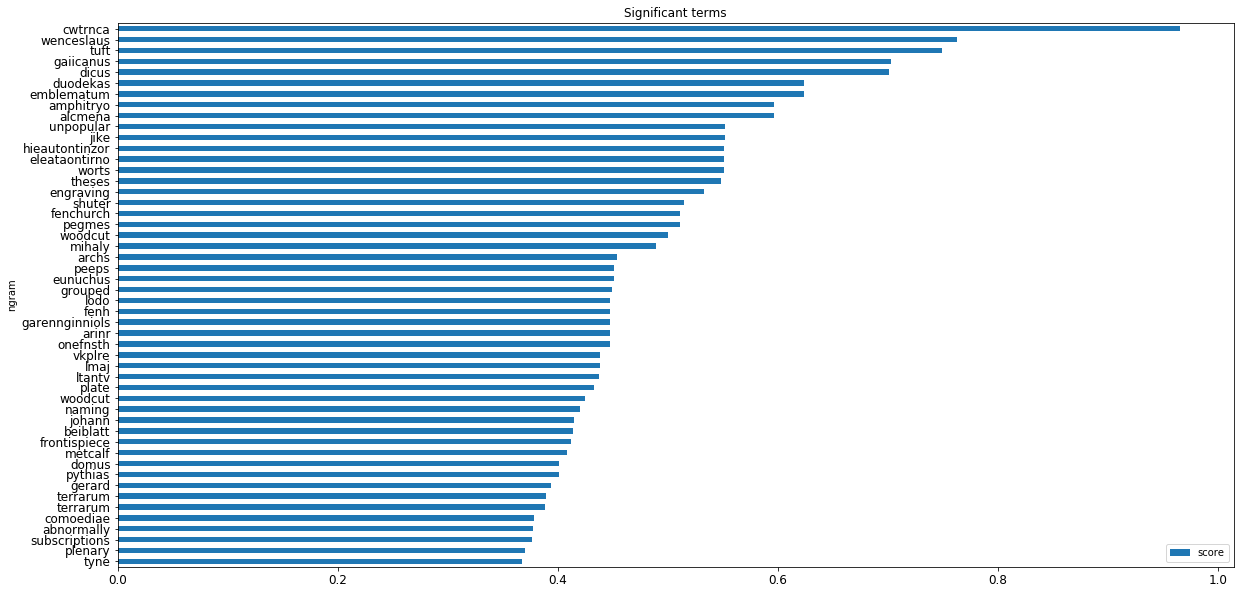

In [32]:
top_50.sort_values("score", ascending=True).plot.barh(title='Significant terms', figsize=(20, 10), fontsize=12, x="ngram", y="score");

In [33]:
import gensim
dictionary = gensim.corpora.Dictionary(documents) # Create the Gensim dictionary based on our ``documents`` variable

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(49145 unique tokens: ['able', 'according', 'achieves', 'activity', 'addition']...) from 499 documents (total 318488 corpus positions)


Now that we have a [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary), we can get a preview that displays the number of unique tokens across all of our texts.

In [34]:
print(dictionary)

Dictionary(49145 unique tokens: ['able', 'according', 'achieves', 'activity', 'addition']...)


The [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary) stores a unique identifier (starting with 0) for every unique token in the corpus. The [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary) does not contain information on word frequencies; it only catalogs all the words in the corpus. You can see the unique ID for each token in the text using the .token2id() method. Your corpus may have hundreds of thousands of unique words so here we just give a preview of the first ten.

In [35]:
dict(list(dictionary.token2id.items())[0:10]) # Print the first ten tokens and their associated IDs.

{'able': 0,
 'according': 1,
 'achieves': 2,
 'activity': 3,
 'addition': 4,
 'adolescence': 5,
 'adolescent': 6,
 'adult': 7,
 'affective': 8,
 'alchemical': 9}

We can also look up the corresponding ID for a token using the ``.get`` method.

In [36]:
dictionary.token2id.get('people', 0) # Get the value for the key 'people'. Return 0 if there is no token matching 'people'. The number returned is the gensim dictionary ID for the token. 

4251

## Creating a Bag of Words Corpus


### A Single Document Example

The next step is to combine our word frequency data found within ``documents`` to our [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary) token IDs. For every document, we want to know how many times a word (notated by its ID) occurs. We can do a single document first to show how this works. We will create a [Python list](https://docs.tdm-pilot.org/key-terms/#python-list) called ``example_bow_corpus`` that will turn our word counts into a series of [tuples](https://docs.tdm-pilot.org/key-terms/#tuple) where the first number is the [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary) token ID and the second number is the word frequency.

In [ ]:
example_bow_corpus = [dictionary.doc2bow(documents[31])] # Create an example bag of words corpus. We select a document at random to use as our sample.
list(example_bow_corpus[0][:10]) # List out the first ten tuples in ``example_bow_corpus``

Using IDs can seem a little abstract, but we can discover the word associated with a particular ID. For demonstration purposes, the following code will replace the token IDs in the last example with the actual tokens.

In [ ]:
word_counts = [[(dictionary[id], count) for id, count in line] for line in example_bow_corpus]
list(word_counts[0][:10])

We saw before that you could discover the [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary) ID number by running:

> dictionary.token2id.get('people', 0)

If you wanted to discover the token given only the ID number, the method is a little more involved. You could use [list comprehension](https://docs.tdm-pilot.org/key-terms/#list-comprehensions) to find the **key** token based on the **value** ID. Normally, [Python dictionaries](https://docs.tdm-pilot.org/key-terms/#python-dictionary) only map from keys to values (not from values to keys). However, we can write a quick [list comprehension](https://docs.tdm-pilot.org/key-terms/#list-comprehensions) to go the other direction. (It is unlikely one would ever do these methods in practice, but they are shown here to demonstrate how the [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary) is connected to the list entries in the [gensim](https://docs.tdm-pilot.org/key-terms/#gensim) ``bow_corpus``. 

In [ ]:
[token for dict_id, token in dictionary.items() if dict_id == 155] # Find the corresponding token in our gensim dictionary for the gensim dictionary ID 239

## Creating a Bag of Words Corpus Using Every Document

We have seen an example that demonstrates how the [gensim](https://docs.tdm-pilot.org/key-terms/#gensim) [bag of words](https://docs.tdm-pilot.org/key-terms/#bag-of-words) [corpus](https://docs.tdm-pilot.org/key-terms/#corpus) works on a single document. Let's apply it now to all of our documents. 

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in documents]
#print(bow_corpus[:3]) #Show the bag of words corpus for the first 3 documents

The next step is to create the [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) model which will set the parameters for our implementation of [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf). In our [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) example, the formula for [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) was:

$$(Times-the-word-occurs-in-given-document) \cdot \mbox{log} \frac{(Total-number-of-documents)}{(Number-of-documents-containing-word)}$$

In [gensim](https://docs.tdm-pilot.org/key-terms/#gensim), the default formula for measuring [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) uses log base 2 instead of log base 10, as shown:

$$(Times-the-word-occurs-in-given-document) \cdot \log_{2} \frac{(Total-number-of-documents)}{(Number-of-documents-containing-the-word)}$$

If you would like to use a different formula for your [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) calculation, there is a description of [parameters you can pass](https://radimrehurek.com/gensim/models/tfidfmodel.html).

In [ ]:
model = gensim.models.TfidfModel(bow_corpus) # Create our gensim TF-IDF model

Now, we apply our model to the ``bow_corpus`` to create our results in ``corpus_tfidf``. The ``corpus_tfidf`` is a python list of each document similar to ``bow_document``. Instead of listing the frequency next to the [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary) ID, however, it contains the TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) score for the associated token. Below, we display the first document in ``corpus_tfidf``. 

In [ ]:
corpus_tfidf = model[bow_corpus] # Create TF-IDF scores for the ``bow_corpus`` using our model
list(corpus_tfidf[0][:10]) # List out the TF-IDF scores for the first 10 tokens of the first text in the corpus

Let's display the tokens instead of the [gensim dictionary](https://docs.tdm-pilot.org/key-terms/#gensim-dictionary) IDs.

In [ ]:
example_tfidf_scores = [[(dictionary[id], count) for id, count in line] for line in corpus_tfidf]
list(example_tfidf_scores[0][:10]) # List out the TF-IDF scores for the first 10 tokens of the first text in the corpus

Finally, let's sort the terms by their [TF-IDF](https://docs.tdm-pilot.org/key-terms/#tf-idf) weights to find the most significant terms in the document.

In [ ]:
# Sort the tuples in our tf-idf scores list

def Sort(tfidf_tuples): 
    tfidf_tuples.sort(key = lambda x: x[1], reverse=True) 
    return tfidf_tuples 

list(Sort(example_tfidf_scores[0])[:10]) #List the top ten tokens in our example document by their TF-IDF scores

We could also analyze across the entire corpus to find the most unique terms. These are terms that appear frequently in a single text, but rarely or never appear in other texts. (Often, these will be proper names since a particular article may mention a name often but the name may rarely appear in other articles.)

In [ ]:
td = { # Define a dictionary ``td`` where each document gather
        dictionary.get(_id): value for doc in corpus_tfidf
        for _id, value in doc
    }
sorted_td = sorted(td.items(), key=lambda kv: kv[1], reverse=True) # Sort the items of ``td`` into a new variable ``sorted_td``, the ``reverse`` starts from highest to lowest

In [ ]:
for term, weight in sorted_td[:25]: # Print the top 25 terms in the entire corpus
    print(term, weight)

And, finally, we can see the most significant term in every document.

In [ ]:
for n, doc in enumerate(corpus_tfidf):
    if len(doc) < 1:
        continue
    word_id, score = max(doc, key=lambda x: x[1])
    print(reduced_list[n].get('id'), dictionary.get(word_id), score)
    if n >= 10:
        break

____
# Start Next Lesson: [LDA Topic Modeling](./1-topic-modeling.ipynb)